In [1]:
import sys
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import optimizers
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend as K

from sklearn.metrics import confusion_matrix
import itertools

from tqdm import tqdm
from scipy import stats

# reserve only the 30% of the GPU memory
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

/data/user/adipilat/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
width = 50
height = 10
channels = 3
classes = 4
dataset_dir = '/data/user/adipilat/ParticleID/genEvts/'
save_dir = '/data/user/adipilat/ParticleID/models/'
plot_dir = '/data/user/adipilat/ParticleID/plots/'
padding = 'padding' + str(height)
model_name= padding + 'testModel'
history_name = model_name + '_history'


# This dictionary should be extended to new classes and antiparticles
class_labels = {22:0, 11:1, 13:2, 211:3}
class_names = np.array(['γ', 'e$^{-}$', 'μ$^{-}$', 'π$^{+}$'])

In [3]:
# arrays of data needed for training

data_array = []
pid_array = []
en_array = []

# read dataset
files = [f for f in os.listdir(dataset_dir) if f.endswith("h5")]

for name in tqdm(files):
    print("Reading file", name)
    data = pd.read_hdf(dataset_dir + name)
    # using 10% of events for test
    n_events_start = int(0.9 * data.event.max()) 
    n_events = int(data.event.max())
    
    for i in range(n_events_start+1, n_events+1):
        tracksters = data.loc[(data['event'] == float(i)) & (data['trackster'] != float(0))]
        n_tracksters = tracksters.trackster.max()
        lead_en = 0
        for j in range(1, int(n_tracksters)+1):
            layerclusters = tracksters.loc[tracksters['trackster'] == float(j)]
            en = np.sum(layerclusters["E"].values)
            if(en>lead_en): #### since I shooted a single particle, only the leading trackster is considered
                lead_en = en
                image = np.zeros(width*height*channels).reshape(width,height,channels)
                pid = int(layerclusters["pid"].iloc[0])
                pid = class_labels[pid]
                en_value = layerclusters["genE"].iloc[0]
                for k in range(1, width+1):
                    layer = layerclusters[layerclusters['layer'] == float(k)]
                    if(len(layer) != 0):
                        temp = layer.E.values, layer.eta.values, layer.phi.values # layer.x.values, layer.y.values, layer.z.values, layer.r.values, layer.nHits.values
                        temp = np.array(temp).T
                        dim = min(temp.shape[0],height)
                        image[k-1][:dim] = temp[:dim]
        data_array.append(image)
        pid_array.append(pid)
        en_array.append(en_value)    

    print("File", name, " processed")

data_array = np.array(data_array)
pid_array = np.array(pid_array)
pid_array_cat = keras.utils.to_categorical(pid_array, num_classes=classes, dtype='float32')
en_array = np.array(en_array)

  0%|          | 0/4 [00:00<?, ?it/s]

Reading file gamma.h5


 25%|██▌       | 1/4 [01:50<05:30, 110.29s/it]

File gamma.h5  processed
Reading file electron.h5


 50%|█████     | 2/4 [03:41<03:41, 110.53s/it]

File electron.h5  processed
Reading file muon.h5


 75%|███████▌  | 3/4 [04:16<01:27, 87.96s/it] 

File muon.h5  processed
Reading file pion_c.h5


100%|██████████| 4/4 [06:17<00:00, 97.86s/it]

File pion_c.h5  processed


In [4]:
print(data_array.shape)
print(en_array.shape)
print(pid_array.shape)

(4000, 50, 10, 3)
(4000,)
(4000,)


In [5]:
####### NORMALIZE THE ENERGY ########

mean_en = 213.90352475881576
std_en = 108.05413626100672

print('Mean Energy Value: {}'.format(mean_en))
print('Std Energy Value: {}'.format(std_en))

en_array_norm = (en_array - mean_en)/std_en

Mean Energy Value: 213.90352475881576
Std Energy Value: 108.05413626100672


In [97]:
# Load the trained model
model = load_model(save_dir + model_name + '.h5')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 50, 10, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 10, 3)    48          input[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 50, 10, 3)    84          conv1[0][0]                      
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, 50, 10, 3)    84          conv2[0][0]                      
__________________________________________________________________________________________________
flatten_11

In [98]:
# Score trained model

scores = model.evaluate(data_array, {'pid_output': pid_array_cat, 'enreg_output': en_array_norm}, verbose=1)
print("Scores: {}".format(scores))

4000/4000 [==============================] - 1s 223us/step
Scores: [0.6674490877389908, 0.3861244231890887, 0.2813246674537659, 0.7915, 0.2813246674537659]


In [99]:
# Perform inference

results = model.predict(data_array)

print('****** PID START*******')
print('True Particle IDs= {} '.format(pid_array))
pid_results = results[0]
pid_predicted = np.argmax(pid_results, axis=1)
print('Predicted Particle ID Probabilities= {} '.format(pid_results))
print('Predicted Particle IDs= {} '.format(pid_predicted))
print('****** PID END*******')

print('****** ENREG START*******')
print('True Particle Energies= {} '.format(en_array))
enreg_results = results[1]
enreg_results = (enreg_results * std_en) + mean_en
enreg_results = np.squeeze(enreg_results)
print('Predicted Particle Energies= {}'.format(enreg_results))
print('****** ENREG END*******')

****** PID START*******
True Particle IDs= [0 0 0 ... 3 3 3] 
Predicted Particle ID Probabilities= [[4.47e-01 5.53e-01 1.37e-15 4.60e-05]
 [5.45e-01 4.03e-01 5.83e-06 5.26e-02]
 [5.12e-01 4.88e-01 2.11e-13 3.64e-04]
 ...
 [3.48e-01 1.41e-01 9.75e-05 5.11e-01]
 [7.34e-05 4.16e-06 2.87e-04 1.00e+00]
 [7.23e-03 1.67e-03 2.05e-02 9.71e-01]] 
Predicted Particle IDs= [1 0 0 ... 3 3 3] 
****** PID END*******
****** ENREG START*******
True Particle Energies= [331.9   73.84 300.18 ... 119.5  262.14  95.23] 
Predicted Particle Energies= [328.72  87.13 285.55 ... 110.32 280.91  94.33]
****** ENREG END*******


In [100]:
gamma_true_en = en_array[pid_array==0]
electron_true_en = en_array[pid_array==1]
muon_true_en = en_array[pid_array==2]
pion_c_true_en = en_array[pid_array==3]

gamma_reco_en = enreg_results[pid_array==0]
electron_reco_en = enreg_results[pid_array==1]
muon_reco_en = enreg_results[pid_array==2]
pion_c_reco_en = enreg_results[pid_array==3]

In [74]:
# Binning energy

gamma_true_en_binned_mean, _, _ = stats.binned_statistic(gamma_true_en, gamma_true_en, statistic='mean', bins=10)
gamma_true_en_binned_std, _, _ = stats.binned_statistic(gamma_true_en, gamma_true_en, statistic='std', bins=10)

electron_true_en_binned_mean, _, _ = stats.binned_statistic(electron_true_en, electron_true_en, statistic='mean', bins=10)
electron_true_en_binned_std, _, _ = stats.binned_statistic(electron_true_en, electron_true_en, statistic='std', bins=10)

muon_true_en_binned_mean, _, _ = stats.binned_statistic(muon_true_en, muon_true_en, statistic='mean', bins=10)
muon_true_en_binned_std, _, _ = stats.binned_statistic(muon_true_en, muon_true_en, statistic='std', bins=10)

pion_c_true_en_binned_mean, _, _ = stats.binned_statistic(pion_c_true_en, pion_c_true_en, statistic='mean', bins=10)
pion_c_true_en_binned_std, _, _ = stats.binned_statistic(pion_c_true_en, pion_c_true_en, statistic='std', bins=10)


gamma_reco_en_binned_mean, _, _ = stats.binned_statistic(gamma_reco_en, gamma_reco_en, statistic='mean', bins=10)
gamma_reco_en_binned_std, _, _ = stats.binned_statistic(gamma_reco_en, gamma_reco_en, statistic='std', bins=10)

electron_reco_en_binned_mean, _, _ = stats.binned_statistic(electron_reco_en, electron_reco_en, statistic='mean', bins=10)
electron_reco_en_binned_std, _, _ = stats.binned_statistic(electron_reco_en, electron_reco_en, statistic='std', bins=10)

muon_reco_en_binned_mean, _, _ = stats.binned_statistic(muon_reco_en, muon_reco_en, statistic='mean', bins=10)
muon_reco_en_binned_std, _, _ = stats.binned_statistic(muon_reco_en, muon_reco_en, statistic='std', bins=10)

pion_c_reco_en_binned_mean, _, _ = stats.binned_statistic(pion_c_reco_en, pion_c_reco_en, statistic='mean', bins=10)
pion_c_reco_en_binned_std, _, _ = stats.binned_statistic(pion_c_reco_en, pion_c_reco_en, statistic='std', bins=10)


In [101]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=13, y=1.04)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black", fontsize=12)

    plt.ylabel('True class', labelpad=10, fontsize=13)
    plt.xlabel('Predicted class', labelpad=10, fontsize=13)
    plt.tight_layout()

Confusion matrix
[[0.7  0.3  0.   0.01]
 [0.49 0.51 0.   0.01]
 [0.   0.   0.99 0.01]
 [0.02 0.   0.01 0.96]]


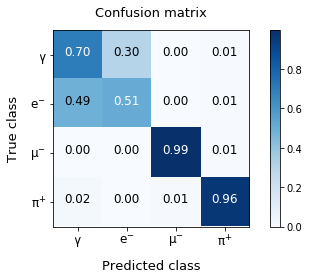

In [102]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(pid_array, pid_predicted)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(0)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Confusion matrix')
plt.savefig(plot_dir + model_name + '_confusion_matrix.pdf', format='pdf')
plt.show()

/data/user/adipilat/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


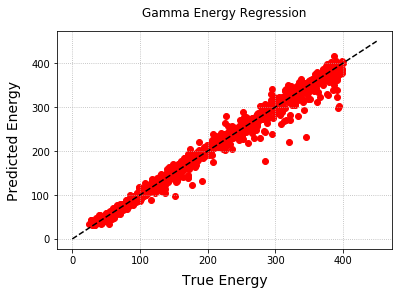

In [31]:
#gamma's energy
fig1 = plt.figure(1)
plt.scatter(gamma_true_en, gamma_reco_en, color='red')
plt.title('Gamma Energy Regression', y=1.04)
plt.xlabel('True Energy', labelpad=8, fontsize=14)
plt.ylabel('Predicted Energy', labelpad=10, fontsize=14)
plt.plot([0,450],[0,450], color='black',linestyle='--')
plt.grid(linestyle=':')
plt.savefig(plot_dir + model_name + '_gammaEn.pdf', format='pdf')
fig1.show()

/data/user/adipilat/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


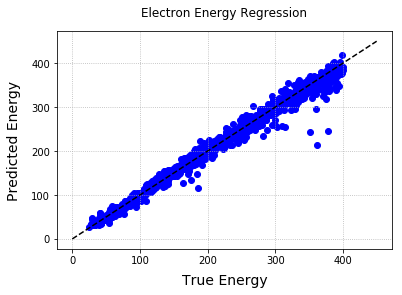

In [14]:
#electron's energy
fig2 = plt.figure(2)
plt.scatter(electron_true_en, electron_reco_en, color='blue')
plt.title('Electron Energy Regression', y=1.04)
plt.xlabel('True Energy', labelpad=8, fontsize=14)
plt.ylabel('Predicted Energy', labelpad=10, fontsize=14)
plt.plot([0,450],[0,450], color='black',linestyle='--')
plt.grid(linestyle=':')
plt.savefig(plot_dir + model_name + '_electronEn.pdf', format='pdf')
fig2.show()

/data/user/adipilat/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


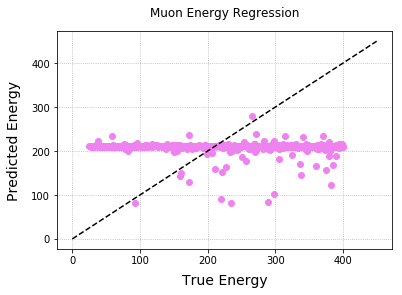

In [116]:
#muon's energy
fig3 = plt.figure(3)
plt.scatter(muon_true_en, muon_reco_en, color='violet')
plt.title('Muon Energy Regression', y=1.04)
plt.xlabel('True Energy', labelpad=8, fontsize=14)
plt.ylabel('Predicted Energy', labelpad=10, fontsize=14)
plt.plot([0,450],[0,450], color='black', linestyle='--')
plt.grid(linestyle=':')
plt.savefig(plot_dir + model_name + '_muonEn.pdf', format='pdf')
fig3.show()

/data/user/adipilat/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


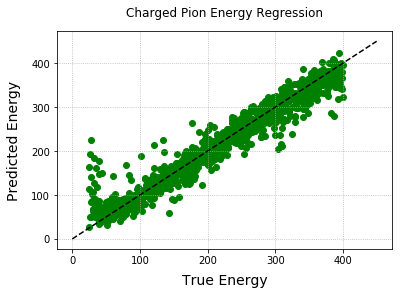

In [127]:
#pion_c's energy
fig4 = plt.figure(4)
plt.scatter(pion_c_true_en, pion_c_reco_en, color='green')
plt.title('Charged Pion Energy Regression', y=1.04)
plt.xlabel('True Energy', labelpad=8, fontsize=14)
plt.ylabel('Predicted Energy', labelpad=10, fontsize=14)
plt.plot([0,450],[0,450], color='black', linestyle='--')
plt.grid(linestyle=':')
plt.savefig(plot_dir + model_name + '_pion_cEn.pdf', format='pdf')
fig4.show()

In [103]:
file = pd.read_hdf(save_dir + history_name + ".h5", "history") #.values
print(file.head())

file = file.values

val_loss = file[:, 0]
val_pid_loss = file[:, 1]
val_en_loss = file[:,2]

val_pid_acc =file[:,3]

train_loss = file[:, 5]
train_pid_loss = file[:,6]
train_en_loss = file[:,7]

train_pid_acc = file[:, 8]

n_epochs = len(file)
n_epochs = np.arange(1, n_epochs+1)
print("Number of Epochs: ", n_epochs)

    val_loss  val_pid_output_loss  val_enreg_output_loss  val_pid_output_acc  \
0   2.134891             1.482241               0.652650            0.000000   
1   2.365911             1.597641               0.768270            0.000000   
2   5.893154             1.754195               4.138958            0.000000   
3  23.122767             1.015965              22.106802            0.816667   
4   4.642415             0.173524               4.468891            0.950556   

   val_enreg_output_mean_squared_error      loss  pid_output_loss  \
0                             0.652650  1.971252         1.381415   
1                             0.768270  1.722041         1.370313   
2                             4.138958  1.664626         1.333028   
3                            22.106802  1.203468         0.867988   
4                             4.468891  0.797617         0.471511   

   enreg_output_loss  pid_output_acc  enreg_output_mean_squared_error  
0           0.589837        0.26

/data/user/adipilat/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


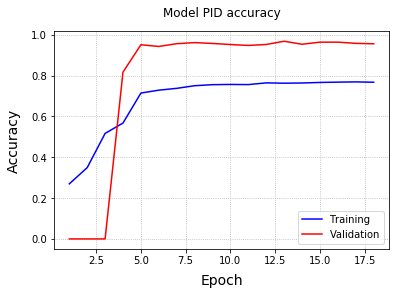

In [104]:
fig5 = plt.figure(5)
plt.plot(n_epochs, train_pid_acc, '-b', label='Training')
plt.plot(n_epochs, val_pid_acc, '-r', label='Validation')

plt.title('Model PID accuracy', y=1.04)
plt.grid(linestyle=':')
plt.xlabel('Epoch', labelpad=8, fontsize=14)
plt.ylabel('Accuracy', labelpad=10, fontsize=14)
plt.legend(loc='lower right')
plt.savefig(plot_dir + model_name + '_pid_accuracy.pdf', format='pdf')
fig5.show()

/data/user/adipilat/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


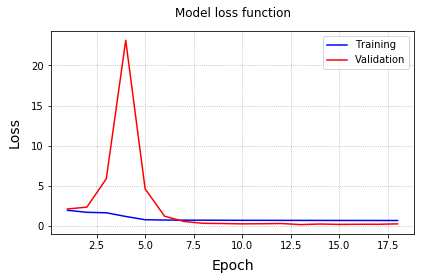

In [105]:
fig6 = plt.figure(6)
plt.plot(n_epochs, train_loss, '-b', label='Training')
plt.plot(n_epochs, val_loss, '-r', label='Validation')

plt.title('Model loss function', y=1.04)
plt.grid(linestyle=':')
plt.xlabel('Epoch', labelpad=8, fontsize=14)
plt.ylabel('Loss', labelpad=10, fontsize=14)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(plot_dir + model_name + '_total_loss.pdf', format='pdf')
fig6.show()

/data/user/adipilat/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


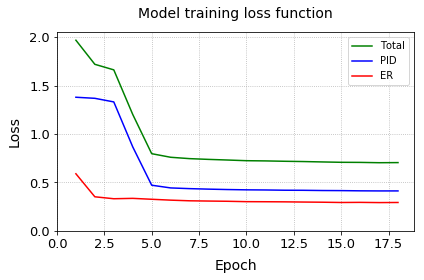

In [106]:
fig7 = plt.figure(7)
plt.plot(n_epochs, train_loss, '-g', label='Total')
plt.plot(n_epochs, train_pid_loss, '-b', label='PID')
plt.plot(n_epochs, train_en_loss, '-r', label='ER')
ax = plt.gca()
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.tick_params(axis = 'y', which = 'major', labelsize = 13)
plt.title('Model training loss function', y=1.04, fontsize=14)
plt.grid(linestyle=':')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel('Epoch', labelpad=8, fontsize=14)
plt.ylabel('Loss', labelpad=8, fontsize=14)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(plot_dir + model_name + '_training_loss.pdf', format='pdf')
fig7.show()

/data/user/adipilat/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


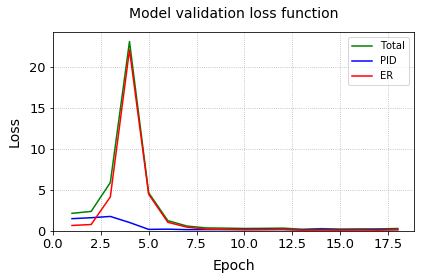

In [107]:
fig8 = plt.figure(8)
plt.plot(n_epochs, val_loss, '-g', label='Total')
plt.plot(n_epochs, val_pid_loss, '-b', label='PID')
plt.plot(n_epochs, val_en_loss, '-r', label='ER')
ax = plt.gca()
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.tick_params(axis = 'y', which = 'major', labelsize = 13)
plt.title('Model validation loss function', y=1.04, fontsize=14)
plt.grid(linestyle=':')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel('Epoch', labelpad=8, fontsize=14)
plt.ylabel('Loss', labelpad=8, fontsize=14)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(plot_dir + model_name + '_validation_loss.pdf', format='pdf')
fig8.show()

In [ ]:
#gamma's binned energy
fig9 = plt.figure(9)
plt.errorbar(gamma_true_en_binned_mean, gamma_reco_en_binned_mean, yerr=gamma_reco_en_binned_std, marker='None', color='firebrick', ls='none')
plt.plot(gamma_true_en_binned_mean, gamma_reco_en_binned_mean, color='firebrick', linestyle='-')
plt.fill_between(gamma_true_en_binned_mean, gamma_true_en_binned_mean-gamma_true_en_binned_std, gamma_true_en_binned_mean+gamma_true_en_binned_std, color='yellow', alpha=0.7)
plt.fill_between(gamma_true_en_binned_mean, gamma_true_en_binned_mean-2*gamma_true_en_binned_std, gamma_true_en_binned_mean-gamma_true_en_binned_std, color='goldenrod', alpha=0.7)
plt.fill_between(gamma_true_en_binned_mean, gamma_true_en_binned_mean+2*gamma_true_en_binned_std, gamma_true_en_binned_mean+gamma_true_en_binned_std, color='goldenrod', alpha=0.7)

plt.title('Gamma Energy Regression', y=1.04)
plt.xlabel('True Energy', labelpad=8, fontsize=14)
plt.ylabel('Predicted Energy', labelpad=10, fontsize=14)
plt.plot([0,450],[0,450], color='black',linestyle='--')
plt.grid(linestyle=':')
plt.xlim(0,450)
plt.ylim(0,450)
plt.savefig(plot_dir + model_name + '_gammaEn_binned.pdf', format='pdf')
fig9.show()

In [ ]:
#electron's binned energy
fig10 = plt.figure(10)
plt.errorbar(electron_true_en_binned_mean, electron_reco_en_binned_mean, yerr=electron_reco_en_binned_std, marker='None', color='blue', ls='none')
plt.plot(electron_true_en_binned_mean, electron_reco_en_binned_mean, color='blue', linestyle='-')
plt.fill_between(electron_true_en_binned_mean, electron_true_en_binned_mean-electron_true_en_binned_std, electron_true_en_binned_mean+electron_true_en_binned_std, color='yellow', alpha=0.7)
plt.fill_between(electron_true_en_binned_mean, electron_true_en_binned_mean-2*electron_true_en_binned_std, electron_true_en_binned_mean-electron_true_en_binned_std, color='goldenrod', alpha=0.7)
plt.fill_between(electron_true_en_binned_mean, electron_true_en_binned_mean+2*electron_true_en_binned_std, electron_true_en_binned_mean+electron_true_en_binned_std, color='goldenrod', alpha=0.7)

plt.title('Electron Energy Regression', y=1.04)
plt.xlabel('True Energy', labelpad=8, fontsize=14)
plt.ylabel('Predicted Energy', labelpad=10, fontsize=14)
plt.plot([0,450],[0,450], color='black',linestyle='--')
plt.grid(linestyle=':')
plt.xlim(0,450)
plt.ylim(0,450)
plt.savefig(plot_dir + model_name + '_electronEn_binned.pdf', format='pdf')
fig10.show()

In [ ]:
#charged pion's binned energy
fig11 = plt.figure(11)
plt.errorbar(pion_c_true_en_binned_mean, pion_c_reco_en_binned_mean, yerr=pion_c_reco_en_binned_std, marker='None', color='darkgreen', ls='none')
plt.plot(pion_c_true_en_binned_mean, pion_c_reco_en_binned_mean, color='darkgreen', linestyle='-')
plt.fill_between(pion_c_true_en_binned_mean, pion_c_true_en_binned_mean-pion_c_true_en_binned_std, pion_c_true_en_binned_mean+pion_c_true_en_binned_std, color='yellow', alpha=0.7)
plt.fill_between(pion_c_true_en_binned_mean, pion_c_true_en_binned_mean-2*pion_c_true_en_binned_std, pion_c_true_en_binned_mean-pion_c_true_en_binned_std, color='goldenrod', alpha=0.7)
plt.fill_between(pion_c_true_en_binned_mean, pion_c_true_en_binned_mean+2*pion_c_true_en_binned_std, pion_c_true_en_binned_mean+pion_c_true_en_binned_std, color='goldenrod', alpha=0.7)

plt.title('Pion+ Energy Regression', y=1.04)
plt.xlabel('True Energy', labelpad=8, fontsize=14)
plt.ylabel('Predicted Energy', labelpad=10, fontsize=14)
plt.plot([0,450],[0,450], color='black',linestyle='--')
plt.grid(linestyle=':')
plt.xlim(0,450)
plt.ylim(0,450)
plt.savefig(plot_dir + model_name + '_pion_cEn_binned.pdf', format='pdf')
fig11.show()

/data/user/adipilat/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


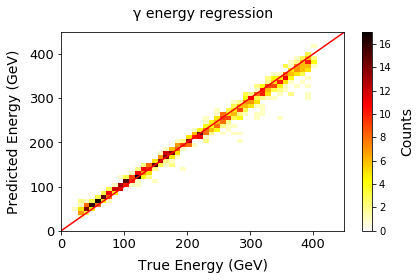

In [108]:
#gamma's energy hist
fig12 = plt.figure(12)
plt.hist2d(gamma_true_en, gamma_reco_en, (50,50), cmap='hot_r', range=[[0, 450], [0, 450]])
plt.title('γ energy regression', y=1.04, fontsize=14)
plt.xlabel('True Energy (GeV)', labelpad=8, fontsize=14)
plt.ylabel('Predicted Energy (GeV)', labelpad=8, fontsize=14)
ax = plt.gca()
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.tick_params(axis = 'y', which = 'major', labelsize = 13)
plt.plot([0,450],[0,450], color='red',linestyle='-')
# plt.grid(linestyle=':')
cbar = plt.colorbar()
cbar.set_label('Counts', fontsize=14, labelpad=8)
plt.tight_layout()
plt.savefig(plot_dir + model_name + '_gammaEnHist.pdf', format='pdf')
fig12.show()

/data/user/adipilat/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


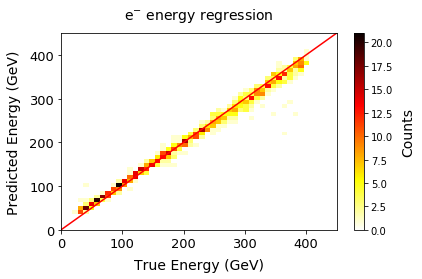

In [109]:
#electron's energy hist
fig13 = plt.figure(13)
plt.hist2d(electron_true_en, electron_reco_en, (50,50), cmap='hot_r', range=[[0, 450], [0, 450]])
plt.title('e$^{-}$ energy regression', y=1.04, fontsize=14)
plt.xlabel('True Energy (GeV)', labelpad=8, fontsize=14)
plt.ylabel('Predicted Energy (GeV)', labelpad=8, fontsize=14)
plt.xlim(0,450)
plt.ylim(0,450)
ax = plt.gca()
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.tick_params(axis = 'y', which = 'major', labelsize = 13)
plt.plot([0,450],[0,450], color='red',linestyle='-')
# plt.grid(linestyle=':')
cbar = plt.colorbar()
cbar.set_label('Counts', fontsize=14, labelpad=8)
plt.tight_layout()
plt.savefig(plot_dir + model_name + '_electronEnHist.pdf', format='pdf')
fig13.show()

/data/user/adipilat/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


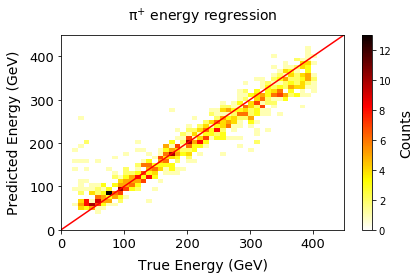

In [110]:
#pion's energy hist
fig14 = plt.figure(14)
plt.hist2d(pion_c_true_en, pion_c_reco_en, (50,50), cmap='hot_r', range=[[0, 450], [0, 450]])
plt.title('π$^{+}$ energy regression', y=1.04, fontsize=14)
plt.xlabel('True Energy (GeV)', labelpad=8, fontsize=14)
plt.ylabel('Predicted Energy (GeV)', labelpad=8, fontsize=14)
plt.xlim(0,450)
plt.ylim(0,450)
ax = plt.gca()
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.tick_params(axis = 'y', which = 'major', labelsize = 13)
plt.plot([0,450],[0,450], color='red',linestyle='-')
# plt.grid(linestyle=':')
cbar = plt.colorbar()
cbar.set_label('Counts', fontsize=14, labelpad=8)
plt.tight_layout()
plt.savefig(plot_dir + model_name + '_pion_cEnHist.pdf', format='pdf')
fig14.show()